# Variational auto-encoder

## Intro

The [variational auto-encoder](https://arxiv.org/abs/1312.6114) has one major difference with other stochastic simulation methods, in that it is interested not only in evaluating expectation of some intractable posterior, but also its gradient

Classical MC deals with $\mathbb{E}_{p}[f(X)]$, where $X \sim p_{\theta}(x)$, by drawing samples $X_i$ from $p$.

Now say we are interested in computing the gradient w.r.t. $\theta$.

The unbiased MC estimator is given by

$$
\nabla_\theta \mathbb{E}_{p}[f(x)] 
= \nabla_\theta \int f(x) \; p_{\theta}(x) dx
$$

$$
= \int f(x) \; \nabla_\theta p_{\theta}(x) dx
$$

$$
= \int \bigg(f(x)\;  \nabla_\theta \log p_{\theta}(x) \bigg) \; p_{\theta}(x) dx
$$

$$
= \mathbb{E}_{p}\bigg[f(x)\;  \nabla_\theta \log p(x) \bigg]
$$

Which we can compute by simulating $X_i \sim p(x)$, assuming we can compute 
$ \nabla_\theta \log p(x) $:

$$
\approx \frac{1}{N} \sum_{j=1}^N f(X^{(j)})\;  \nabla_\theta \log p(X^{(j)}) 
$$

This is also known as the score function estimator

## Reparameterization trick

The unbiased estimator has large variance. Usually as long as $f(x)$ is differentiable, we can use the trick:

Consider 
$ x = g_{\theta}(\epsilon) $, where $\epsilon \sim p(\epsilon)$ is some auxiliary variable with no parameter of interest.

We usually deal with the gaussian case $ X \sim \mathbb{N}(\mu_{\theta}, \Sigma_{\theta}) $,
so we write $ X = \mu_{\theta} + \sigma_{\theta} \epsilon $, 

where $ \epsilon \sim \mathbb{N}(0, I) $, $ \sigma_{\theta} \sigma_{\theta}^T = \Sigma$,
and $ \mu_{\theta}, \sigma_{\theta} $ are deterministic functions parametrized by $\theta$. 

Where $\Sigma$ is not diagonal, we can find $ \sigma_{\theta} $ with Chelosky

Then we init $\mu_{\theta}, \sigma_{\theta}$ and simulate $\epsilon^{(j)}$, 
compute $ X^{(j)} = \mu_{\theta} + \sigma_{\theta} \cdot \epsilon^{(j)} $, so that

$$
\mathbb{E}_{x \sim p}\bigg[f(x)\bigg] = \mathbb{E}_{p(\epsilon)} \left[ f(\mu_{\theta} + \sigma_{\theta} \cdot \epsilon^{(j)}) \right]
$$

and

$$
\nabla_\theta \mathbb{E}_{x \sim p}\bigg[f(x)\bigg] = \nabla_\theta \mathbb{E}_{p(\epsilon)} \left[ f(\mu_{\theta} + \sigma_{\theta} \cdot \epsilon^{(j)}) \right]
$$

So that all we have to do is to simulate $\epsilon \sim p(\epsilon)$, compute MC estimate of $f(\mu_{\theta} + \sigma_{\theta} \cdot \epsilon^{(j)})$, then differentiate it


## Bayesian Setup for VAE

Now consider $E_q [ p(x | z) ] $, where $ z \sim q_{\phi}(z | x) $, and 
$ x \sim p_{\theta}(x | z) $

With the usual setup $z \in \mathbb{R}^d$ is latent, and $d$ is the latent_dim.

Let posterior $ q_{\phi}(z | x) = \mathbb{N}(\mu_{\phi}(x), \sigma_{\phi}(x))$

The likelihood $ p(x | z)$ is either gaussian or Bernoulli (for binary image, where each pixel is 0 or 1). In this case let 
$ p_{\theta}(x | z) = \mathbb{N}(\mu_{\theta}(z), \sigma_{\theta}(z))$

As we with to learn the best $p_{\theta}$ and $q_{\phi}$ given the data $x$, we wish to compute $ \nabla_\theta E_q [ p(x | z) ]$ and $ \nabla_\phi E_q [ p(x | z) ]$, which will be used to update $\mu_{\theta}, \sigma_{\theta}, \mu_{\phi}, \sigma_{\phi}$. 

In fact in the VAE case, $p_{\theta}$ is a neural net named `Decoder`, which takes $z$ as input, and outputs the tuple $ ( \mu_{\theta}(z), \sigma_{\theta}(z) )$,
with $\theta$ be its parameters which we will perform SGD.

Similarly $q_{\phi}$ is the `Encoder` neural net which takes $x$ and outputs a distribution for $z$, given by $\mu_{\phi}, \sigma_{\phi}$ and parametrized by $\phi$





Given data $x$, we evaluate $ \nabla_{(\theta, \phi)} E_q [ p(x | z) ]$

The unbiased score-based estimator is

$$
\nabla_\phi E_{q}[ p(x | z) ] = \nabla_\phi \int p(x | z) \; q_\phi(z | x) dz
$$

$$
= E_{q} \bigg[ p(x | z) \cdot \nabla_\phi \log q_\phi(z | x) \bigg]
$$

By simulating $z^{(j)} = \mu_{\phi}(x) + \sigma_{\phi}(x) \cdot \epsilon^{(j)} $, we can do

$$
\approx \frac{1}{N} \sum_{j=1}^N \; \bigg[ p(x | z^{(j)}) \bigg]
$$



## ELBO

### Deriving ELBO

Consider the log marginal likelihood 

$$
\log p(x) = \log \int p(x | z) p(z) dz
$$

$$
= \log \int p(x | z) \frac{p(z)}{q(z | x)} q(z | x) dz
$$

By Jensen's inequality we have

$$
\geq \int \log \bigg( p(x | z) \frac{p(z)}{q(z | x)} \bigg) q(z | x) dz
$$

$$
= \int \log p(x | z) \; q(z | x) dz - \int \log \bigg( \frac{q(z | x)}{p(z)} \bigg) q(z | x) dz
$$

$$
= E_{q(z|x)} [\log p(x | z)] - D_{KL} (q(z | x) \; ||  \; p(z))
$$

This is the ELBO (a lower bound of the log likelihood, often a negative number).   The negative ELBO is given by

$$
= - E_{q(z|x)} [\log p(x | z)] + D_{KL} (q(z | x) \; ||  \; p(z))
$$

Where the first term is the recon loss (negative log likelihood loss), and the second term is the KL loss. We want to minimize recon loss (maximizing likelihood under our best posterior $q(z|x)$), while keeping $q(z|x)$ not too far from prior

Note that

\begin{align*}
D_{KL}(q_\phi(z \mid x) \| p_\theta(z \mid x)) 
&= \int q_\phi(z \mid x) \log \left( \frac{q_\phi(z \mid x)}{p_\theta(z \mid x)} \right) dz \\

&= \int q_\phi(z \mid x) \log \left( \frac{q_\phi(z \mid x) p_\theta(x)}{p_\theta(x \mid z) p(z)} \right) dz \\

&= E_{q(z \mid x)}[ \log p_\theta(x) ]
- E_{q(z \mid x)}[ \log p_\theta(x \mid z) ] \\
&\quad + E_{q(z \mid x)}[ \log \left( \frac{q_\phi(z \mid x)}{p(z)} \right) ] \\

&= \log p_\theta(x) - E_{q(z|x)} [\log p(x | z)] + D_{KL} (q(z | x) \; ||  \; p(z)) \\

&= \log p_\theta(x) - ELBO
\end{align*}

This means that as we maximize ELBO towards its upper bound $ \log p_\theta(x) $, we are minimizing $D_{KL}(q_\phi(z \mid x) \| p_\theta(z \mid x)) $ at the same time, hence making our posterior converge to the true posterior $ p_\theta(z \mid x) $

### Computing ELBO Loss

We know -ELBO = Recon_loss + KL

Denote ELBO as $\mathcal{L}(\theta, \phi; x)$, we have

$$
\mathcal{L}(\theta, \phi; x) = E_{q(z|x)} [\log p(x | z)] - D_{KL} (q(z | x) \; ||  \; p(z))
$$

$$
= E_{q(z \mid x)}[ \log p_\theta(x | z)] 
- E_{q(z \mid x)}[ \log \left( \frac{q_\phi(z \mid x)}{p(z)} \right) ]
$$

$$
= E_{q(z \mid x)} \bigg[ \log p_\theta(x | z) + \log p(z)
-  \log \left( q_\phi(z \mid x) \right) \bigg]
$$

The unbiased MC estimator (SGVB) is given by sampling 
$z^{(j)} = \mu_{\phi}(x) + \sigma_{\phi}(x) \cdot \epsilon^{(j)} $

$$
\hat{\mathcal{L}}^L = \frac{1}{L} \sum \log p_\theta(x | z^{(j)}) + \log p(z^{(j)})
-  \log \left( q_\phi(z^{(j)} \mid x) \right) 
$$

Then the gradient $ \nabla_{(\theta, \phi)} \hat{\mathcal{L}}$ is evaluated on a mini-batch $\{X_i\}_{i \in \mathbb{D}_m}$.

Since we are using the reparametrization, this estimator has very low variance, and we can even set $L = 1$

So that with each batch of data $x$ (64, 28, 28), we only sample (64,) $\epsilon$ to obtain $\hat{z} \sim \mathbb{N}(\mu_z, \sigma_z^2) = q(z \mid x) $, 

$\hat{z}$ is fed into decoder to obtain $ \mu_x, \sigma_x $, where $ p(x \mid z) = \mathbb{N}(\mu_x, \sigma_x^2) $

We can then evaluate the recon loss as $ - \log p(x \mid \hat{z}) $ as the one-sample MC estimate of $ E_q [- \log p(x \mid z)] $

The full MC algo is given by

- Init $ \phi, \theta, L $
- Sample minibatch of data $x$ (64, 28, 28)
- Obtain $ q_\phi(z \mid x) = N(\mu_z, \Sigma) $ with encoder(x)
- Sample $\epsilon_{ij}$ for each $x_i$ in batch,  $j = 1, ...,  L$, shape $(64, L)$
- Obtain $\hat{z}_{ij} \sim q(z \mid x) = \mu_z + \Sigma \cdot \epsilon$
- Obtain batch MC estimate for recon loss: $ - \frac{1}{L} \sum \log p(x \mid z^{(j)}) $
- Obtain batch MC estimate for KL div: $ - \frac{1}{L} \sum \log \frac{p(z^{(j)})}{\left( q_\phi(z^{(j)} \mid x) \right)} $
- Compute batch grad $ \frac{1}{M} \sum_{x_i \in \mathbb{D}_m} \nabla_{(\theta, \phi)}  \hat{\mathcal{L}}^L$
- Update SGD on $ \theta, \phi $



### Recon Loss

Like above, we showed that by simulating $z^{(j)} = \mu_{\phi}(x) + \sigma_{\phi}(x) \cdot \epsilon^{(j)} $

$$
\nabla_\phi E_{q}[ \log p(x | z) ] = E_{q} \bigg[ \log p(x | z) \cdot \nabla_\phi \log q_\phi(z | x) \bigg]
$$

$$
\approx \frac{1}{N} \sum_{j=1}^N \; \bigg[ \log p(x | z^{(j)}) \cdot  \nabla_\phi \log q_\phi(z^{(j)} | x) \bigg]
$$

and

$$
\nabla_\theta E_{q}[ \log p(x | z) ] = E_{q}[ \nabla_\theta \log p(x | z) ]
$$

$$
\approx \frac{1}{N} \sum_{j=1}^N \; \bigg[ \nabla_\theta \log p(x | z^{(j)}) \cdot q_\phi(z^{(j)} | x) \bigg]
$$

We can pick $N = 1$, which has been shown to work well empirically. Even if some data generates noisy estimate of the grad, averaging over a mini-batch often smoothes it out

When implementing, we do not need to manually implement the grad taking step, but we only need to make the encoder($\phi$) and decoder($\theta$) differentiable, and outputs the MC estimate for the loss 
$$
-E_{q}[ \log p(x | z) ] \approx -\log p(x | z^{(j)})
$$

Then we simply call autograd and optimizer to compute the grad and perform SGD
```python
loss.backward()
gradients = [v.value.grad for v in self.trainable_weights]    
with torch.no_grad():
    optimizer.apply(gradients, self.trainable_weights)
```




In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras
from keras import ops

def compute_nll(self, data):
    z_mean, z_log_var = self.encoder(data)
    epsilon = keras.random.normal(ops.shape(z_mean))
    z_std = ops.exp(0.5 * z_log_var)
    z_sample = z_mean + (z_std * epsilon)
    
    x_mean, x_log_std = self.decoder(z_sample)
    log_Z = 0.5 * ops.log(2 * self.pi)
    nll_loss = 0.5 * ops.square((data - x_mean) / ops.exp(x_log_std)) + x_log_std + log_Z
    nll_loss = ops.mean(ops.sum(nll_loss, axis=[-1, -2]))

### KL Div

To compute KL Div, while one could do MC estimate of KL after sampling $z^{(j)}$:

$$
\mathrm{KL}(q \| p) = E_{q(z \mid x)}[ \log \left( \frac{q_\phi(z \mid x)}{p(z)} \right) ]

= - \frac{1}{L} \sum_j \log p(z^{(j)}) + \log \left( q_\phi(z^{(j)} \mid x) \right) 
$$

In our case when $ q(z \mid x) $ and prior $ p(z) $ are both gaussian, KL can be computed analytically (as soon as we have $ q(z \mid x) $ using the encoder)

Let

$$
p(z) = \mathbb{N}(z; 0, I) \\ 
q_\phi(z \mid x) = \mathbb{N}(z; \mu, \Sigma) 
$$

Where $\mu \in R^d $ is output of $\mu_\phi(x)$, and $\Sigma = \text{diag}(\sigma_1^2 \dots \sigma^2_d)$ is output of $\sigma_\phi(x)$, where $d$ is the latent_dim, often set to 2.

Then we have

$$
q_\phi(z \mid x) = \frac{1}{(2\pi)^{d/2}\prod_{i=1}^{d}\sigma_i}\exp\left(-\frac{1}{2}\sum_{i=1}^{d}\frac{(z_i-\mu_i)^2}{\sigma_i^2}\right)
$$

$$
\log q(z) = -\frac{d}{2}\log(2\pi) - \sum_{i=1}^{d}\log \sigma_i - \frac{1}{2}\sum_{i=1}^{d}\frac{(z_i-\mu_i)^2}{\sigma_i^2}
$$

$$
\log p(z) = -\frac{d}{2}\log(2\pi) - \frac{1}{2}\sum_{i=1}^{d}z_i^2
$$

So that

$$
\log q(z) - \log p(z) = - \sum_{i=1}^{d}\log \sigma_i - \frac{1}{2}\sum_{i=1}^{d}\left(\frac{(z_i-\mu_i)^2}{\sigma_i^2} - z_i^2\right)
$$

We have that under $z \sim q(z|x)$:

$$
\mathbb{E}_{q}[(z_i-\mu_i)^2] = \sigma_i^2 \quad \; 
\mathbb{E}_{q}[z_i^2] = \sigma_i^2 + \mu_i^2
$$

So that

$$
\mathrm{KL}(q \| p)(x) = \mathbb{E}_{q(z|x)}\left[ \log q(z|x) - \log p(z) \right]
$$

$$
= - \sum_{i=1}^{d}\log \sigma_i - \frac{1}{2}\sum_{i=1}^{d}\left(1 - \sigma_i^2 - \mu_i^2\right)
$$

$$
= \frac{1}{2}\sum_{i=1}^{d} \left(\sigma_i^2 + \mu_i^2 - 1 - \log \sigma_i^2\right)
$$

This is then averaged across the mini-batch for computation of the batch gradient:



In [2]:
def compute_kl(self, data):
    z_mean, z_log_var = self.encoder(data)
    kl_loss = 0.5 * ops.sum((ops.square(z_mean) + ops.exp(z_log_var) - 1 - z_log_var), axis=-1)
    kl_loss = ops.mean(kl_loss)

## Full Algorithm

Now being able to compute KL analytically, we do

- Init `Encoder` with params $ \phi$, decoder with $\theta$, set $L=1$
- Sample minibatch of data $x$ (64, 28, 28)
- Forward pass `Encoder`$f_{\phi}(x)$ = $(\mu_z, \log \Sigma)$, each (64, 2)
- Obtain $ q_\phi(z \mid x) = N(\mu_z, \Sigma) $
- Use $ q_\phi(z \mid x) $ to compute KL div analytically
- Obtain $\sigma_z = \exp(0.5 \log \Sigma)$
- Simulate $\hat{z}_{j} \sim q(z \mid x) = \mu_z + \sigma_z \cdot \epsilon$
- Forward pass `Decoder` $f_{\theta}(\hat{z}_{j})$ = $(\mu_x, \Sigma_x)$
- Obtain $ p(x \mid z^{(j)}) = N(\mu_x, \Sigma_x) $
- Plug in $\hat{z}_{j}$ for recon loss: $ - \log p(x \mid z^{(j)}) $
- output loss = KL div + recon loss to autograd 
- SGD with `Encoder` and `Decoder`


## Full VAE setup on MNIST

The full setup on MNIST, using torch backend and Keras API:

### Preprocessing

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()
type(x_train), x_train.shape, y_train.shape

(numpy.ndarray, (60000, 28, 28), (60000,))

In [4]:
from torch.utils.data import TensorDataset, DataLoader

def preprocess(image, label):
    return ops.cast(image, 'float32') / 255., ops.one_hot(label, 10)

x_train, y_train = preprocess(x_train, y_train)
x_val, y_val = preprocess(x_val, y_val)

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

### Encoder

The encoder $f_{\phi}(x)$ takes a batch of images, (64, 28, 28), and returns $\mu_z$ and $\log \sigma^2_z$,  
where $ q(z \mid x) = \mathbb{N}(\mu_z, \text{Diag}(\sigma^2_z)) $

$\mu_z$ and $\log \sigma^2_z$ are of shape (64, 2), where 2 is latent dim

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten

latent_dim = 2
image_shape = (28, 28)

image_input = Input(shape=image_shape, name='image')

x = Flatten()(image_input)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(2 * latent_dim)(x)

z_mean, z_log_var = ops.split(x, 2, axis=-1)

encoder = Model(inputs=image_input, outputs=[z_mean, z_log_var], name='encoder')

z_mean, z_log_var = encoder([keras.random.normal((64, 28, 28))])
z_mean.shape, z_log_var.shape

/home/jx1421/DL_TensorFlow_Imperial/DL_venv/lib64/python3.9/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image
Received: inputs=['Tensor(shape=torch.Size([64, 28, 28]))']
  warnings.warn(msg)


(torch.Size([64, 2]), torch.Size([64, 2]))

### Decoder

The decoder $f_\theta(z)$ takes a batch of $\hat{z} = \mu_z + \sigma_z \cdot \epsilon \sim q(z \mid x)$, (64, 2)   
and returns the mean of the reconstructed image $\mu_x$ (64, 28, 28)

where we assumed $\sigma^2_x=0.5$, s.t. $ p(x \mid z) = \mathbb{N}(\mu_x, \text{Diag}(0.5)) $

In [6]:
from keras.layers import Reshape

z_input = Input(shape=(latent_dim,), name='z')

x = Dense(512, activation='relu')(z_input)
x = Dense(512, activation='relu')(x)
x = Dense(28 * 28)(x)
x = Reshape((28, 28))(x)
decoded_image = ops.sigmoid(x)

decoder = Model(inputs=z_input, outputs=decoded_image, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z (InputLayer)                  │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       402,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Sigmoid)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,384 (2.54 MB)

 Trainable params: 666,384 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

### VAE

In [7]:
from keras.metrics import Mean
import torch
import numpy as np

class VAE(Model):
    def __init__(self, encoder, decoder, num_mc_samples=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_metric = Mean(name='loss')
        self.nll_metric = Mean(name='nll')
        self.kl_metric = Mean(name='kl')
        self.pi = ops.array(np.pi)
        self.L = num_mc_samples
        
    def compute_losses(self, data):
        z_mean, z_log_var = self.encoder(data[0])
        kl_loss = (0.5 * ops.sum((ops.square(z_mean) 
                + ops.exp(z_log_var) - 1 - z_log_var), axis=-1))
        kl_loss = ops.mean(kl_loss)
        
        epsilon = keras.random.normal(ops.shape(z_mean))
        z_std = ops.exp(0.5 * z_log_var)
        z_sample = z_mean + (z_std * epsilon)
        
        x_mean = self.decoder(z_sample)
        log_Z = 0.5 * ops.log(2 * self.pi)

        # recon loss, or p(x|z) = N(x|mu, 0.5)
        nll_loss = (0.5 * ops.square((data[0] - x_mean)
                 / 0.5) + ops.log(0.5) + log_Z)
        nll_loss = ops.mean(ops.sum(nll_loss, axis=[-1, -2]))

        loss = kl_loss + nll_loss
        return loss, kl_loss, nll_loss

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = keras.random.normal(ops.shape(z_mean))
        z_std = ops.exp(0.5 * z_log_var)
        z_sample = z_mean + (z_std * epsilon)
        return self.decoder(z_sample)

    def train_step(self, data):
        assert keras.config.backend() == 'torch'
        self.zero_grad()
        loss, kl_loss, nll_loss = self.compute_losses(data)
        loss = ops.mean(loss)

        loss.backward()

        gradients = [v.value.grad for v in self.trainable_weights]    
        with torch.no_grad():
            self.optimizer.apply(gradients, self.trainable_weights)
            
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        loss, kl_loss, nll_loss = self.compute_losses(data)
        loss = ops.mean(loss)
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    @property
    def metrics(self):
        return [self.loss_metric, self.nll_metric, self.kl_metric]

In [8]:
vae = VAE(encoder, decoder)
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10)
vae.compile(optimizer="adam")

# Manually call the model with a batch of data to build it
for batch in train_loader:
    vae(batch[0])
    break
history = vae.fit(train_loader, validation_data=val_loader, 
        epochs=20, callbacks=[early_stop])

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl: 4.4977 - loss: 280.1234 - nll: 275.6256 - val_kl: 4.6310 - val_loss: 254.6410 - val_nll: 250.0101
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - kl: 4.8191 - loss: 252.8121 - nll: 247.9931 - val_kl: 5.3388 - val_loss: 248.5372 - val_nll: 243.1984
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl: 5.3350 - loss: 248.1796 - nll: 242.8446 - val_kl: 5.4204 - val_loss: 246.6304 - val_nll: 241.2100
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - kl: 5.5311 - loss: 246.1467 - nll: 240.6157 - val_kl: 5.4211 - val_loss: 245.3051 - val_nll: 239.8839
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl: 5.6911 - loss: 244.7868 - nll: 239.0956 - val_kl: 5.8418 - val_loss: 244.1463 - val_nll: 238.3045
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - kl: 5.8211 - loss: 243.5906 - nll: 237.7696 - val_kl: 5.6949 - val_loss: 243.4613 - val_nll: 237.7663
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/ste

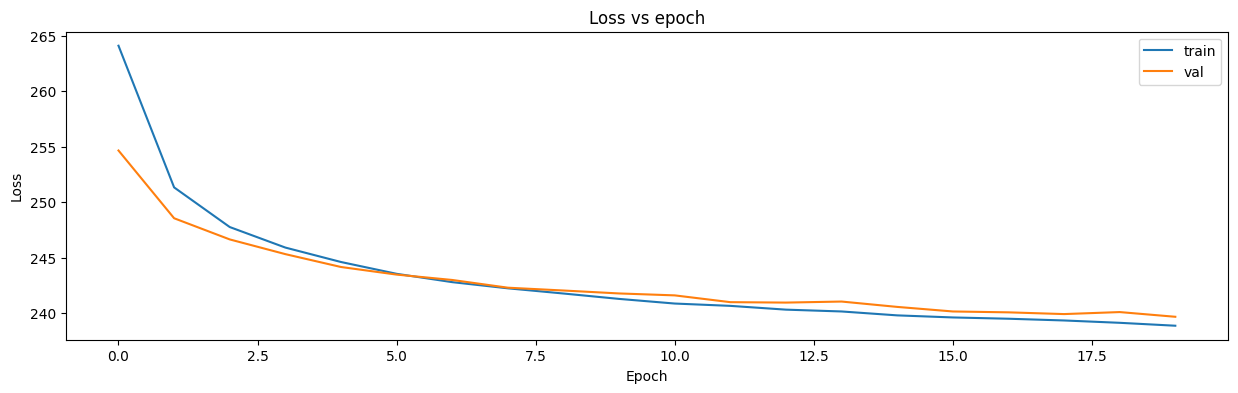

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
plt.legend()

In [10]:
vae.evaluate(val_loader, return_dict=True)

  1/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - kl: 6.3114 - loss: 236.7239 - nll: 230.4125

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl: 6.2407 - loss: 240.2854 - nll: 234.0447


{'kl': 6.324409008026123, 'loss': 239.7041473388672, 'nll': 233.37974548339844}

### Visualization

To visualize VAE, we simply generate random $\hat{z}$ in the latent space. 

Note the idea of VAE is that given an image $x$, if we can obtain the right posterior $q(z \mid x)$ (thru training the encoder), then passing a sample $\hat{z} \sim q(z \mid x) $ into the decoder should yield a $x_{recon}$ sufficiently close to $x$

We can visualize the learnt posterior $q(z|x=x_{val})$, and generate some $z \sim \mathbb{N}(0, I)$, and inspect which $x_{val}$ most likely generated this $z$. 

Then we can obtain $x_{recon}$ with the `decoder`, and inspect if it agrees with $x_{val}$

decoded image shape: (1, 28, 28)


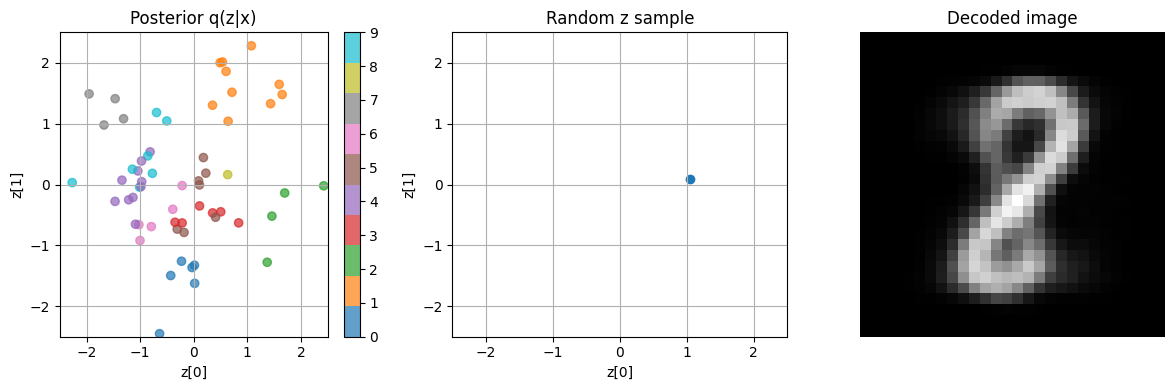

In [33]:
# visualize the posterior q(z|x) for a batch of data
for batch in val_loader:
    images, labels = batch
    z_mean, z_log_var = vae.encoder(images)
    break

# convert one-hot labels to class indices
labels = torch.argmax(labels, dim=1).cpu().numpy()
z_mean = z_mean.cpu().detach().numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# subplot 1: plot Posterior q(z|x)
sc = axs[0].scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10', alpha=0.7)
axs[0].set_title("Posterior q(z|x)")
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_xlim(-2.5, 2.5)
axs[0].set_ylim(-2.5, 2.5)
axs[0].grid(True)

# Add colorbar to subplot 1
cbar = fig.colorbar(sc, ax=axs[0], ticks=range(10))

# generate one random z ~ N(0, I)
z_random = keras.random.normal((1, latent_dim))
z_rand_np = z_random.cpu().detach().numpy() # for plotting

decoded_images = vae.decoder(z_random)
decoded_images = ops.convert_to_numpy(decoded_images)

print('decoded image shape:', decoded_images.shape)

# Subplot 2: Random latent z (inspect where z is in q(z|x) space)
axs[1].scatter(z_rand_np[:, 0], z_rand_np[:, 1])
axs[1].set_title("Random z sample")
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_xlim(-2.5, 2.5)
axs[1].set_ylim(-2.5, 2.5)
axs[1].grid(True)

# Subplot 3: Decoded image
axs[2].imshow(decoded_images[0], cmap='gray')
axs[2].set_title("Decoded image")
axs[2].axis('off')

plt.tight_layout()
plt.show()


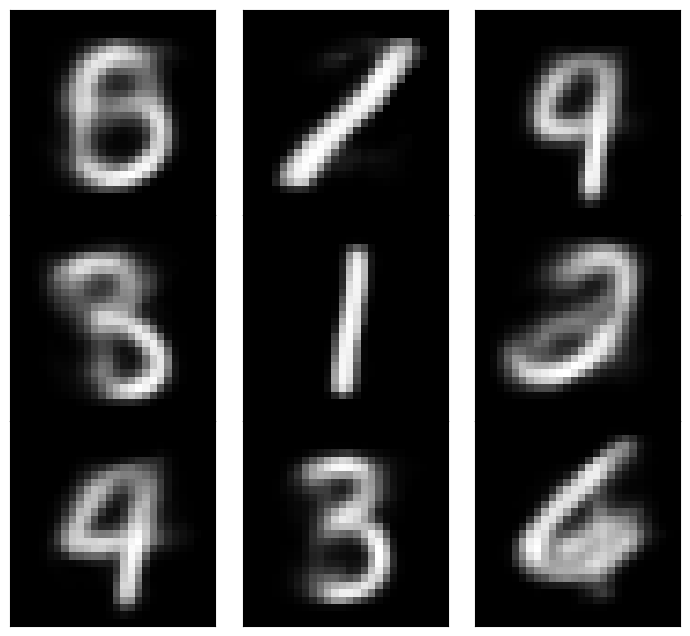

In [34]:
# generate 9 random z ~ N(0, I)
z_random = keras.random.normal((9, latent_dim))
decoded_images = ops.convert_to_numpy(vae.decoder(z_random))

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 8))
fig.subplots_adjust(hspace=0., wspace=0.)
for n, image in enumerate(decoded_images):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()